In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd

In [15]:
airbnb=pd.read_csv("AB_NYC_2019.csv")
airbnb.drop(['id','host_name','last_review'], axis=1, inplace=True)
airbnb.fillna({'reviews_per_month':0}, inplace=True)
airbnb = airbnb[airbnb.price < 500]
airbnb.head(3)

,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Clean & quiet apt home by the park,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Skylit Midtown Castle,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,THE VILLAGE OF HARLEM....NEW YORK !,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365


In [16]:
airbnb = gpd.GeoDataFrame(airbnb, geometry=gpd.points_from_xy(airbnb.longitude, airbnb.latitude))
airbnb.set_crs(epsg=4326, inplace=True)
airbnb.shape

(47660, 14)

In [17]:
zips = gpd.read_file('zipcode/ZIP_CODE_040114.shp')
zips["COUNTY"].replace({
    "Bronx": "BRONX",
    "Queens": "QUEENS",
    "New York": "MANHATTAN",
    "Kings": "BROOKLYN", 
    "Richmond": "STATEN ISLAND"
}, inplace=True)
zips.drop_duplicates(subset=['ZIPCODE'], inplace=True)
zips.to_crs(epsg=4326, inplace=True)
zips.head(1)

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,QUEENS,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.80585 40.68291, -73.80569 40.682..."


In [18]:
zips = zips[['ZIPCODE','geometry']]
airbnb = gpd.sjoin(zips, airbnb)
airbnb.head(3)

,ZIPCODE,geometry,index_right,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,11436,"POLYGON ((-73.80585 40.68291, -73.80569 40.682...",47848,Penn House~~~~5 mins from JFK,269113892,Queens,Jamaica,40.68248,-73.79417,Entire home/apt,128,1,5,5.00,1,176
0,11436,"POLYGON ((-73.80585 40.68291, -73.80569 40.682...",23516,Ms. Dee Cozy Bedroom you feel like home!! Room 2,97794385,Queens,Jamaica,40.68347,-73.79461,Private room,60,2,42,1.65,2,0
0,11436,"POLYGON ((-73.80585 40.68291, -73.80569 40.682...",18672,Immaculate Private Apt Under $10 Uber to JFK*,72838963,Queens,Jamaica,40.68358,-73.79670,Entire home/apt,66,1,94,2.71,2,180


In [19]:
g = airbnb.groupby('ZIPCODE').agg({'host_id':'count', 'geometry':'first'})
g.head()

,host_id,geometry
ZIPCODE,,
10001,535,"POLYGON ((-74.00827 40.75259, -74.00819 40.752..."
10002,1212,"POLYGON ((-73.97442 40.73642, -73.97445 40.736..."
10003,994,"POLYGON ((-73.97986 40.73497, -73.98028 40.734..."
10004,128,"POLYGON ((-74.01101 40.70622, -74.00997 40.705..."
10005,281,"POLYGON ((-74.00597 40.70432, -74.00600 40.704..."


# Airbnb Activity Density

<AxesSubplot:>

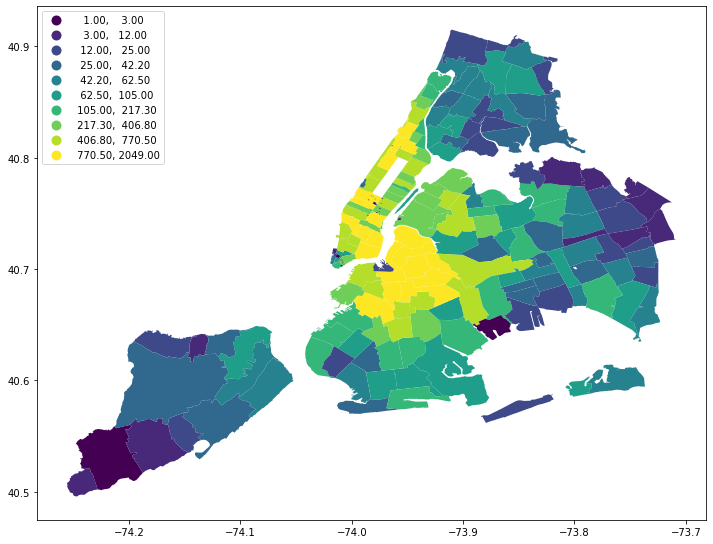

In [20]:
fig, ax = plt.subplots(1, figsize=(12,12))
g = gpd.GeoDataFrame(g, geometry='geometry')
g.plot(ax=ax, column='host_id', k=10, scheme='Quantiles', legend=True, 
              legend_kwds={'loc': 'upper left'})

In [28]:
crime = pd.read_csv('NYPD_Arrests_Data__Historic_.csv')

In [29]:
crime['ARREST_DATE'] = pd.to_datetime(crime['ARREST_DATE'])

In [30]:
crime = crime[crime['ARREST_DATE'].dt.year==2019]
crime.head(1)

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat
1,192799737,2019-01-26,177.0,SEXUAL ABUSE,116.0,SEX CRIMES,PL 1306503,F,M,25,0.0,45-64,M,BLACK,1000555.0,230994.0,40.800694,-73.941109,POINT (-73.94110928599997 40.800694331000045)


In [31]:
crime = gpd.GeoDataFrame(crime, geometry=gpd.points_from_xy(crime.Longitude, crime.Latitude), crs="EPSG:4326")
crime.set_crs(epsg=4326, inplace=True)
crime = gpd.sjoin(zips, crime)
crime.head(1)

,ZIPCODE,geometry,index_right,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,...,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat
0,11436,"POLYGON ((-73.80585 40.68291, -73.80569 40.682...",145760,200728347,2019-08-06,101.0,ASSAULT 3,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1200001,...,113,0.0,45-64,M,WHITE HISPANIC,1041758.0,188692.0,40.684414,-73.79265,POINT (-73.79264984299994 40.68441412000004)


In [32]:
crime.shape

(212268, 22)

In [33]:
crime.columns

Index(['ZIPCODE', 'geometry', 'index_right', 'ARREST_KEY', 'ARREST_DATE',
       'PD_CD', 'PD_DESC', 'KY_CD', 'OFNS_DESC', 'LAW_CODE', 'LAW_CAT_CD',
       'ARREST_BORO', 'ARREST_PRECINCT', 'JURISDICTION_CODE', 'AGE_GROUP',
       'PERP_SEX', 'PERP_RACE', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude',
       'Longitude', 'Lon_Lat'],
      dtype='object')

In [34]:
g1 = crime.groupby('ZIPCODE').agg({'ARREST_KEY': 'count', 'geometry': 'first'})
g1.shape

(192, 2)

In [36]:
g1.head(1)

,ARREST_KEY,geometry
ZIPCODE,,
00083,179,"POLYGON ((-73.94922 40.79691, -73.94932 40.796..."


<AxesSubplot:>

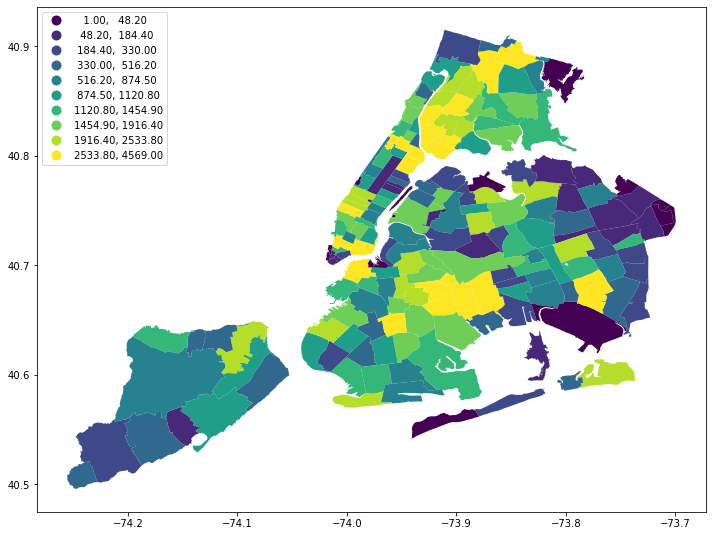

In [37]:
fig, ax = plt.subplots(1, figsize=(12,12))
g1 = gpd.GeoDataFrame(g1, geometry='geometry')
g1.plot(ax=ax, column='ARREST_KEY', k=10, scheme='Quantiles', legend=True, 
              legend_kwds={'loc': 'upper left'})

In [38]:
g.shape

(204, 2)

In [40]:
g1.shape

(192, 2)

In [47]:
data = g.merge(g1, left_on='ZIPCODE', right_on='ZIPCODE', how='inner')
data.dropna()
data.shape

(180, 4)

In [49]:
d = data[['host_id', 'ARREST_KEY']]
d.corr()


,host_id,ARREST_KEY
host_id,1.000000,0.245828
ARREST_KEY,0.245828,1.000000


In [50]:
d1 = pd.DataFrame(data = {'host':np.log(d['host_id']), 'ARREST_KEY':np.log(d['ARREST_KEY'])})
d1.corr()

,host,ARREST_KEY
host,1.000000,0.532769
ARREST_KEY,0.532769,1.000000
